In [ ]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.7 MB/s eta 0:00:00


2120it [15:03,  3.09it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2030
  warnings.warn(
2122it [15:04,  2.95it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1740
  warnings.warn(
2123it [15:05,  2.85it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1913
  warnings.warn(
2208it [15:44,  2.35it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1664
  warnings.warn(
2618it [18:28,  2.43it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1852
  warnings.warn(
2632it [18:33,  2.48it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: 

Epoch 1/100
109/110 [============================>.] - ETA: 0s - loss: 2.5410 - accuracy: 0.1855

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 23s 155ms/step - loss: 2.5397 - accuracy: 0.1858 - val_loss: 2.0332 - val_accuracy: 0.2702
Epoch 2/100
110/110 [==============================] - 13s 117ms/step - loss: 2.0088 - accuracy: 0.3145 - val_loss: 1.7752 - val_accuracy: 0.3618
Epoch 3/100
110/110 [==============================] - 12s 113ms/step - loss: 1.7631 - accuracy: 0.3696 - val_loss: 1.4783 - val_accuracy: 0.4711
Epoch 4/100
110/110 [==============================] - 11s 97ms/step - loss: 1.6197 - accuracy: 0.4369 - val_loss: 1.4074 - val_accuracy: 0.5054
Epoch 5/100
110/110 [==============================] - 12s 109ms/step - loss: 1.5399 - accuracy: 0.4578 - val_loss: 1.3702 - val_accuracy: 0.5135
Epoch 6/100
110/110 [==============================] - 13s 120ms/step - loss: 1.4725 - accuracy: 0.4830 - val_loss: 1.3136 - val_accuracy: 0.5301
Epoch 7/100
110/110 [==============================] - 13s 114ms/step - loss: 1.4043 - accuracy: 0.5072 - val_loss: 1.2513 - val_accuracy

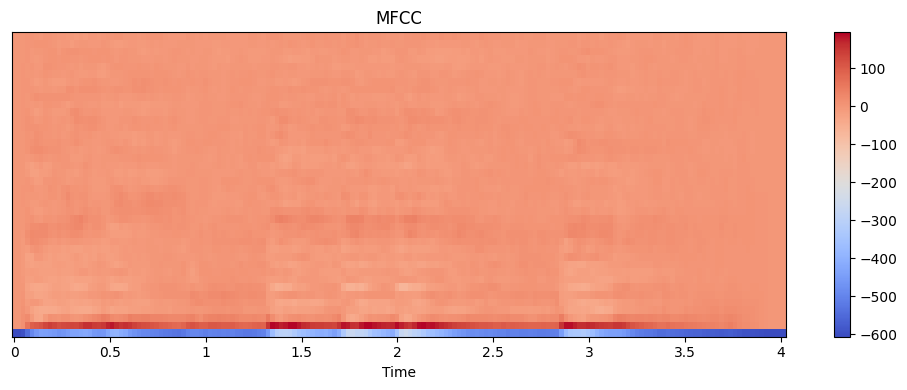

1/1 [==============================] - 1s 923ms/step


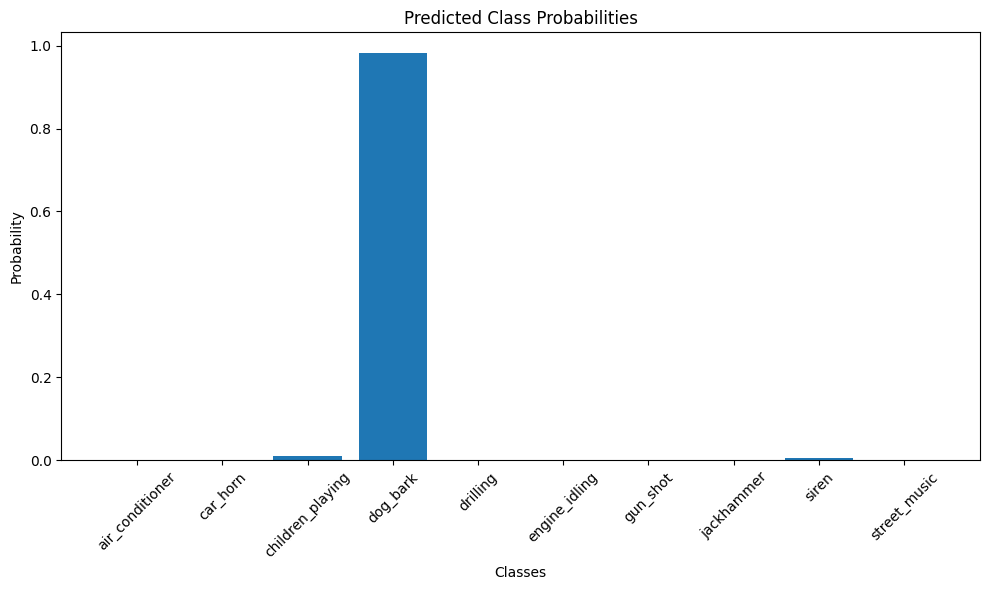

ValueError: Input 0 of layer "conv1d_1" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 10)

In [ ]:
import pandas as pd
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, LSTM, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

# Set your audio dataset path
audio_dataset_path = '/content/drive/MyDrive/UrbanSounds/audio'

# Load metadata
metadata = pd.read_csv('/content/drive/MyDrive/UrbanSounds/metadata/UrbanSound8K.csv')

# Extract MFCC features
def features_extractor(file_name, noise_threshold=0.001):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')

    # Apply a fading window function to simulate fading effect
    fade_length = min(int(0.1 * sample_rate), len(audio) // 2)  # Assuming a fade-in and fade-out length of 0.1 seconds
    fade_window = np.concatenate((np.linspace(0, 1, fade_length), np.ones(len(audio) - 2 * fade_length), np.linspace(1, 0, fade_length)))
    audio *= fade_window

    audio = audio[np.abs(audio) > noise_threshold]
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

# Features extraction from all audio files (MFCC)
extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), 'fold' + str(row["fold"]) + '/', str(row["slice_file_name"]))
    final_class_labels = row["class"]
    data = features_extractor(file_name)
    extracted_features.append([data, final_class_labels])

# Convert extracted_features to Pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])

# Data Splitting
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

# Label Encoding
labelencoder = LabelEncoder()
y_encoded = to_categorical(labelencoder.fit_transform(y))

# Training Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=0)

# Model definition
model = Sequential()

# Convolutional Layer
model.add(Conv1D(filters=128, kernel_size=5, padding='same', input_shape=(X_train.shape[1], 1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# LSTM Layer
model.add(LSTM(units=128, return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Flatten Layer
model.add(Flatten())

# Dense Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(len(labelencoder.classes_), activation='softmax'))

# Model Compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Training with EarlyStopping
num_epochs = 100
num_batch_size = 64

checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/UrbanSounds/saved_models/audio_classification.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(X_test, y_test), callbacks=[checkpointer, early_stopping], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

# Evaluate the model on the test set
test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", test_accuracy[1])

# Save the trained model
model.save('/content/drive/MyDrive/UrbanSounds/saved_models/final_model.h5')

# Perform predictions on new data
filename = "/content/drive/MyDrive/UrbanSounds/dog_bark1.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast')

# Apply fading window function to simulate fading effect
fade_length = int(0.1 * sample_rate)  # Assuming a fade-in and fade-out length of 0.1 seconds
fade_window = np.concatenate((np.linspace(0, 1, fade_length), np.ones(len(audio) - 2 * fade_length), np.linspace(1, 0, fade_length)))
audio *= fade_window

# Plot MFCC graph
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_features, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

# Predict class probabilities
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
mfccs_scaled_features = mfccs_scaled_features.reshape(1, mfccs_scaled_features.shape[0], 1)
predicted_probabilities = model.predict(mfccs_scaled_features)[0]
classes = labelencoder.classes_

# Plot predicted class probabilities
plt.figure(figsize=(10, 6))
plt.bar(classes, predicted_probabilities)
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title('Predicted Class Probabilities')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

model.add(Conv1D(filters=128, kernel_size=5, padding='same', input_shape=(X_train.shape[1], 1)))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_pred = np.argmax(model.predict(X_test), axis=1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
